In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

def load_and_validate_data(attributes_file, usage_file):
    """Load and validate datasets."""
    try:
        df_attributes = pd.read_excel(attributes_file)
        df_usage = pd.read_excel(usage_file)

        df_usage.rename(columns={"Number of link clicks":"Number of clicks"}, inplace=True)

        # Handle missing values
        df_attributes.fillna({'Acct type': 'SMB', 'Activate chat bot': 'N', 'Converted to paid customer': 0}, inplace=True)
        df_usage.dropna(subset=['Number of clicks', 'Date time'], inplace=True)

        # Validate date format
        df_usage['Date time'] = pd.to_datetime(df_usage['Date time'], errors='coerce')
        if df_usage['Date time'].isnull().any():
            raise ValueError("Invalid date formats in usage data")

        return df_attributes, df_usage
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Change the path of the datasets
df_attributes, df_usage = load_and_validate_data("/content/account_attributes.xlsx","/content/account_usage.xlsx")

In [4]:
df_attributes.head()


,Acct id,Acct type,Activate chat bot,Converted to paid customer
0,SA25212,SMB,Y,0
1,SA34768,SMB,Y,0
2,SA71541,ENT,N,0
3,SA66933,SMB,Y,0
4,SA79773,ENT,Y,1


In [5]:
df_usage.head()

,Acct id,Date time,Number of clicks
0,SA25212,2019-10-06,2311
1,SA25212,2019-10-13,1020
2,SA25212,2019-10-20,1664
3,SA25212,2019-10-27,2523
4,SA25212,2019-11-03,1157


In [6]:
def preprocess_data(df_attributes, df_usage):
    """Merge datasets and compute aggregate metrics."""
    try:
        # Aggregate usage data
        usage_agg = df_usage.groupby('Acct id').agg({
            'Number of clicks': ['sum', 'mean', 'count'],
            'Date time': ['min', 'max']
        }).reset_index()
        usage_agg.columns = ['Acct id', 'total_clicks', 'avg_weekly_clicks', 'num_weeks_active', 'first_active_date', 'last_active_date']

        # Calculate trial duration
        usage_agg['trial_duration_days'] = (usage_agg['last_active_date'] - usage_agg['first_active_date']).dt.days

        # Merge with attributes
        df_merged = pd.merge(df_attributes, usage_agg, on='Acct id', how='left')
        df_merged.fillna({'total_clicks': 0, 'avg_weekly_clicks': 0, 'num_weeks_active': 0, 'trial_duration_days': 0}, inplace=True)

        return df_merged, df_usage
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        raise

df_merged, df_usage = preprocess_data(df_attributes,df_usage)

In [7]:
def analyze_performance(df_merged, df_usage, output_dir="output_trial_analysis"):
    """Calculate conversion rates and usage metrics for Task 1."""
    try:
        os.makedirs(output_dir, exist_ok=True)

        total_accounts = len(df_merged)
        conversion_rate = df_merged['Converted to paid customer'].mean() * 100
        smb_conversion = df_merged[df_merged['Acct type'] == 'SMB']['Converted to paid customer'].mean() * 100
        ent_conversion = df_merged[df_merged['Acct type'] == 'ENT']['Converted to paid customer'].mean() * 100
        chatbot_conversion = df_merged[df_merged['Activate chat bot'] == 'Y']['Converted to paid customer'].mean() * 100
        no_chatbot_conversion = df_merged[df_merged['Activate chat bot'] == 'N']['Converted to paid customer'].mean() * 100

        # Engagement metrics
        avg_clicks_converted = df_merged[df_merged['Converted to paid customer'] == 1]['total_clicks'].mean()
        avg_clicks_non_converted = df_merged[df_merged['Converted to paid customer'] == 0]['total_clicks'].mean()
        avg_duration_converted = df_merged[df_merged['Converted to paid customer'] == 1]['trial_duration_days'].mean()
        avg_duration_non_converted = df_merged[df_merged['Converted to paid customer'] == 0]['trial_duration_days'].mean()

        # Weekly click trends
        df_usage['Week'] = df_usage['Date time'].dt.isocalendar().week
        weekly_clicks = df_usage.groupby(['Acct id', 'Week'])['Number of clicks'].sum().reset_index()
        weekly_clicks_avg = weekly_clicks.groupby('Week')['Number of clicks'].mean().reset_index()

        insights = {
            'total_accounts': total_accounts,
            'conversion_rate': conversion_rate,
            'smb_conversion': smb_conversion,
            'ent_conversion': ent_conversion,
            'chatbot_conversion': chatbot_conversion,
            'no_chatbot_conversion': no_chatbot_conversion,
            'avg_clicks_converted': avg_clicks_converted,
            'avg_clicks_non_converted': avg_clicks_non_converted,
            'avg_duration_converted': avg_duration_converted,
            'avg_duration_non_converted': avg_duration_non_converted,
            'weekly_clicks_avg': weekly_clicks_avg.to_dict()
        }

        # Save insights
        insights_text = f"""
### AnswerForce Trial Program Performance Insights
- Total Accounts: {total_accounts}
- Overall Conversion Rate: {conversion_rate:.2f}%
- SMB Conversion Rate: {smb_conversion:.2f}% (for accounts with <1,000 employees)
- ENT Conversion Rate: {ent_conversion:.2f}% (for accounts with >=1,000 employees)
- Chatbot Activated Conversion Rate: {chatbot_conversion:.2f}%
- No Chatbot Conversion Rate: {no_chatbot_conversion:.2f}%
- Average Total Clicks (Converted): {avg_clicks_converted:.2f}
- Average Total Clicks (Non-Converted): {avg_clicks_non_converted:.2f}
- Average Trial Duration (Converted): {avg_duration_converted:.2f} days
- Average Trial Duration (Non-Converted): {avg_duration_non_converted:.2f} days
"""
        with open(os.path.join(output_dir, 'performance_insights.txt'), 'w') as f:
            f.write(insights_text)

        return insights, df_merged, df_usage, weekly_clicks_avg
    except Exception as e:
        print(f"Error in performance analysis: {e}")
        raise
insights, df_merged, df_usage, weekly_clicks_avg = analyze_performance(df_merged,df_usage)


In [8]:
print(insights)

{'total_accounts': 8000, 'conversion_rate': np.float64(31.624999999999996), 'smb_conversion': np.float64(18.95169578622816), 'ent_conversion': np.float64(51.291866028708135), 'chatbot_conversion': np.float64(41.12682481751825), 'no_chatbot_conversion': np.float64(20.10508849557522), 'avg_clicks_converted': np.float64(10280.558102766798), 'avg_clicks_non_converted': np.float64(7747.959414990859), 'avg_duration_converted': np.float64(62.872727272727275), 'avg_duration_non_converted': np.float64(63.52851919561243), 'weekly_clicks_avg': {'Week': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53}, 'Number of clicks': {0: 843.4511910322279, 1:

# Display visualizations for Performance of trial run.

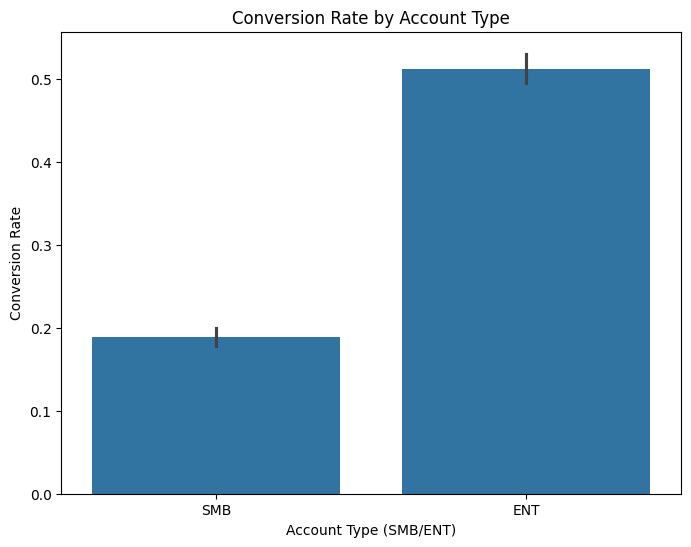

In [9]:

# Conversion rate by account type
plt.figure(figsize=(8, 6))
sns.barplot(x='Acct type', y='Converted to paid customer', data=df_merged)
plt.title('Conversion Rate by Account Type')
plt.xlabel('Account Type (SMB/ENT)')
plt.ylabel('Conversion Rate')
plt.show()
plt.close()


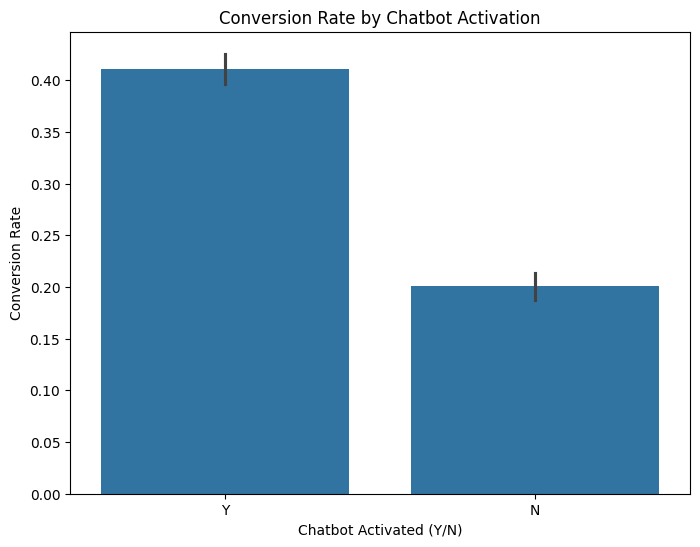

In [10]:
# Conversion rate by chatbot activation
plt.figure(figsize=(8, 6))
sns.barplot(x='Activate chat bot', y='Converted to paid customer', data=df_merged)
plt.title('Conversion Rate by Chatbot Activation')
plt.xlabel('Chatbot Activated (Y/N)')
plt.ylabel('Conversion Rate')
plt.show()
plt.close()


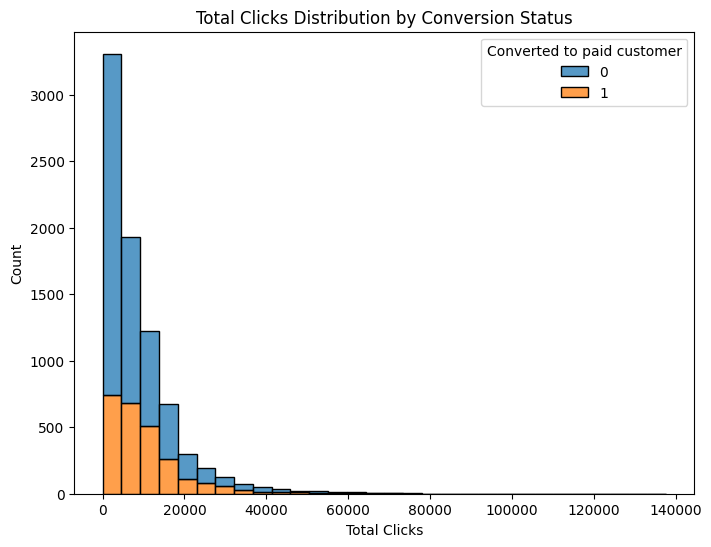

In [11]:
# Click distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df_merged, x='total_clicks', hue='Converted to paid customer', multiple='stack', bins=30)
plt.title('Total Clicks Distribution by Conversion Status')
plt.xlabel('Total Clicks')
plt.ylabel('Count')
plt.show()
plt.close()

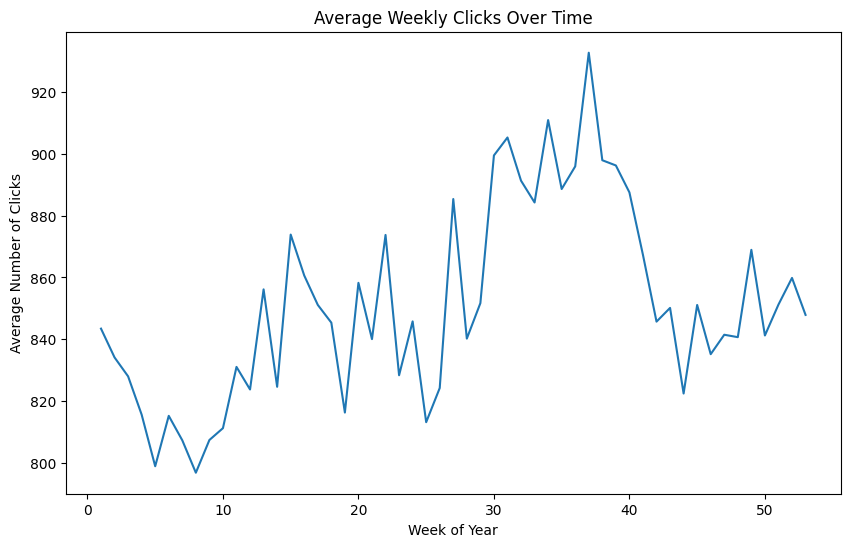

In [13]:
# Weekly click trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='Week', y='Number of clicks', data=weekly_clicks_avg)
plt.title('Average Weekly Clicks Over Time')
plt.xlabel('Week of Year')
plt.ylabel('Average Number of Clicks')
plt.show()
plt.close()

# Improvement recommendations

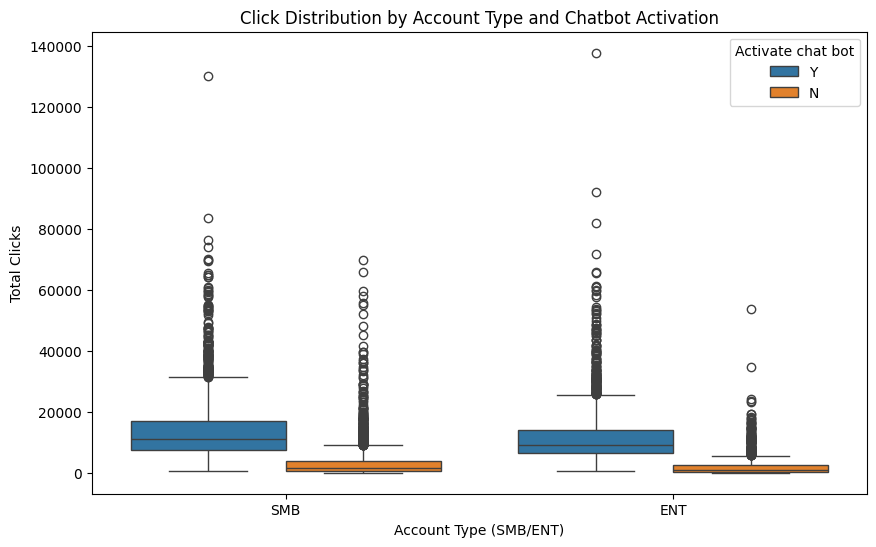

In [ ]:
def analyze_improvements(df_merged, insights, output_dir="output_trial_analysis"):
    """Generate recommendations for improving the trial program for Task 2."""
    try:
        os.makedirs(output_dir, exist_ok=True)

        # Calculate low engagement threshold
        low_engagement_threshold = df_merged['total_clicks'].quantile(0.25)
        low_engagement_conversion = df_merged[df_merged['total_clicks'] < low_engagement_threshold]['Converted to paid customer'].mean() * 100

        recommendations = f"""
### Recommendations to Improve AnswerForce Trial Program
1. Promote Chatbot Adoption:
   - Accounts with chatbot activated convert at {insights['chatbot_conversion']:.2f}% vs {insights['no_chatbot_conversion']:.2f}% for non-chatbot users.
   - Offer in-trial tutorials, pop-up prompts, or incentives (e.g., extended trial) to encourage enabling 'Activate chat bot'.
2. Target Enterprise Accounts:
   - ENT accounts convert at {insights['ent_conversion']:.2f}% vs {insights['smb_conversion']:.2f}% for SMB.
   - Provide tailored onboarding for ENT accounts, focusing on integration with existing systems.
3. Increase User Engagement:
   - Converted accounts have higher average clicks ({insights['avg_clicks_converted']:.2f} vs {insights['avg_clicks_non_converted']:.2f}).
   - Introduce gamification (e.g., badges for exploring features) or email reminders.
4. Address Low Engagement Early:
   - Accounts in the lowest 25% of clicks (threshold: {low_engagement_threshold:.2f}) have a conversion rate of {low_engagement_conversion:.2f}%.
   - Implement proactive support (e.g., live demos, support calls) within the first 2 weeks for low-click accounts.
5. Optimize Trial Duration:
   - Converted accounts have longer trial durations ({insights['avg_duration_converted']:.2f} days vs {insights['avg_duration_non_converted']:.2f} days).
   - Consider tiered trial periods: shorter for low-engagement SMBs, longer for high-engagement ENT accounts.
"""
        with open(os.path.join(output_dir, 'recommendations.txt'), 'w') as f:
            f.write(recommendations)

        # Create box plot for Task 2
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Acct type', y='total_clicks', hue='Activate chat bot', data=df_merged)
        plt.title('Click Distribution by Account Type and Chatbot Activation')
        plt.xlabel('Account Type (SMB/ENT)')
        plt.ylabel('Total Clicks')
        plt.savefig(os.path.join(output_dir, 'clicks_boxplot.png'))
        plt.show()
        plt.close()

        return recommendations
    except Exception as e:
        print(f"Error in improvement analysis: {e}")
        raise
recommendations = analyze_improvements(df_merged, insights)

In [ ]:
print(recommendations)


### Recommendations to Improve AnswerForce Trial Program
1. Promote Chatbot Adoption:
   - Accounts with chatbot activated convert at 41.13% vs 20.11% for non-chatbot users.
   - Offer in-trial tutorials, pop-up prompts, or incentives (e.g., extended trial) to encourage enabling 'Activate chat bot'.
2. Target Enterprise Accounts:
   - ENT accounts convert at 51.29% vs 18.95% for SMB.
   - Provide tailored onboarding for ENT accounts, focusing on integration with existing systems.
3. Increase User Engagement:
   - Converted accounts have higher average clicks (10280.56 vs 7747.96).
   - Introduce gamification (e.g., badges for exploring features) or email reminders.
4. Address Low Engagement Early:
   - Accounts in the lowest 25% of clicks (threshold: 1435.75) have a conversion rate of 20.55%.
   - Implement proactive support (e.g., live demos, support calls) within the first 2 weeks for low-click accounts.
5. Optimize Trial Duration:
   - Converted accounts have longer trial durations

# POC on Different Models to Select Best Model


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

def train_and_evaluate_models(attributes_file="account_attributes.xlsx", usage_file="account_usage.xlsx", output_dir="output_task3"):
    """Train and evaluate multiple models with hyperparameter tuning and feature engineering."""
    try:
        # Load and validate data
        df_attributes = pd.read_excel(attributes_file)
        df_usage = pd.read_excel(usage_file)

        df_usage.rename(columns={"Number of link clicks":"Number of clicks"}, inplace=True)

        # Handle missing values
        df_attributes.fillna({'Acct type': 'SMB', 'Activate chat bot': 'N', 'Converted to paid customer': 0}, inplace=True)
        df_usage.dropna(subset=['Number of clicks', 'Date time'], inplace=True)
        df_usage['Date time'] = pd.to_datetime(df_usage['Date time'], errors='coerce')
        if df_usage['Date time'].isnull().any():
            raise ValueError("Invalid date formats in usage data")

        # Aggregate usage data
        usage_agg = df_usage.groupby('Acct id').agg({
            'Number of clicks': ['sum', 'mean', 'count'],
            'Date time': ['min', 'max']
        }).reset_index()
        usage_agg.columns = ['Acct id', 'total_clicks', 'avg_weekly_clicks', 'num_weeks_active', 'first_active_date', 'last_active_date']
        usage_agg['trial_duration_days'] = (usage_agg['last_active_date'] - usage_agg['first_active_date']).dt.days

        # Add click variability (standard deviation of weekly clicks)
        df_usage['Week'] = df_usage['Date time'].dt.isocalendar().week
        weekly_clicks = df_usage.groupby(['Acct id', 'Week'])['Number of clicks'].sum().reset_index()
        click_variability = weekly_clicks.groupby('Acct id')['Number of clicks'].std().reset_index()
        click_variability.columns = ['Acct id', 'click_variability']
        usage_agg = pd.merge(usage_agg, click_variability, on='Acct id', how='left')
        usage_agg['click_variability'].fillna(0, inplace=True)

        # Merge with attributes
        df_merged = pd.merge(df_attributes, usage_agg, on='Acct id', how='left')
        df_merged.fillna({'total_clicks': 0, 'avg_weekly_clicks': 0, 'num_weeks_active': 0, 'trial_duration_days': 0, 'click_variability': 0}, inplace=True)

        # Encode categorical features
        le_acct_type = LabelEncoder()
        le_chatbot = LabelEncoder()
        df_merged['Acct type'] = le_acct_type.fit_transform(df_merged['Acct type'])
        df_merged['Activate chat bot'] = le_chatbot.fit_transform(df_merged['Activate chat bot'])

        # Feature engineering: interaction term
        df_merged['clicks_chatbot_interaction'] = df_merged['total_clicks'] * df_merged['Activate chat bot']

        # Prepare features and target
        features = ['Acct type', 'Activate chat bot', 'total_clicks', 'avg_weekly_clicks', 'num_weeks_active', 'trial_duration_days', 'click_variability', 'clicks_chatbot_interaction']
        X = df_merged[features]
        y = df_merged['Converted to paid customer']

        # Scale numerical features
        scaler = StandardScaler()
        numerical_features = ['total_clicks', 'avg_weekly_clicks', 'num_weeks_active', 'trial_duration_days', 'click_variability', 'clicks_chatbot_interaction']
        X[numerical_features] = scaler.fit_transform(X[numerical_features])

        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Define models and parameter grids for GridSearchCV
        models = {
            'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }),
            'Random Forest': (RandomForestClassifier(random_state=42), {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            }),
            'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }),
            'SVM': (SVC(random_state=42), {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear']
            }),
            'KNN': (KNeighborsClassifier(), {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance']
            })
        }

        # Train and evaluate models with GridSearchCV
        model_accuracies = {}
        best_estimators = {}
        for name, (model, param_grid) in models.items():
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_estimators[name] = grid_search.best_estimator_
            y_pred = grid_search.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            model_accuracies[name] = accuracy

        # Voting Classifier (ensemble of top models)
        voting_clf = VotingClassifier(
            estimators=[
                ('lr', best_estimators['Logistic Regression']),
                ('rf', best_estimators['Random Forest']),
                ('gb', best_estimators['Gradient Boosting'])
            ],
            voting='soft'
        )
        voting_clf.fit(X_train, y_train)
        y_pred = voting_clf.predict(X_test)
        model_accuracies['Voting Classifier'] = accuracy_score(y_test, y_pred)

        # Save performance
        os.makedirs(output_dir, exist_ok=True)
        performance_text = f"""
### Model Performance Results
Model Accuracies:
{' '.join([f'- {name}: {acc:.4f}' for name, acc in model_accuracies.items()])}
Best Model: {max(model_accuracies, key=model_accuracies.get)} (Accuracy: {max(model_accuracies.values()):.4f})
"""
        with open(os.path.join(output_dir, 'model_performance.txt'), 'w') as f:
            f.write(performance_text)

        return model_accuracies
    except Exception as e:
        print(f"Error in model training: {e}")
        raise

if __name__ == "__main__":
    accuracies = train_and_evaluate_models()
    print("Model Accuracies:")
    for name, acc in accuracies.items():
        print(f"- {name}: {acc:.4f}")

/tmp/ipython-input-56-2551373102.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  usage_agg['click_variability'].fillna(0, inplace=True)
/tmp/ipython-input-56-2551373102.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = scaler.fit_transform(X[numerical_feat

Model Accuracies:
- Logistic Regression: 0.6755
- Random Forest: 0.7473
- Gradient Boosting: 0.7299
- SVM: 0.7144
- KNN: 0.7386
- Voting Classifier: 0.7445
